# Lecture 10: BVP's, Jacobi Method

**Overview:**
* Laplace and Poisson equations.
* The Jacobi (diffusion) method.

**Next Lecture:**
* Simple random systems and diffusion.
---


## Tasks
- Make sure you understand the Jacobi update using array slicing.
- Find V(x,y) and E(x,y) for an infinitely long rectangular cylinder with the two vertical walls at a potential of +1 and the horizontal walls at a potential of -1.
- Include a term for a charge in the Jacobi algorithm (Poisson equation).
- Find V(x,y) and E(x,y) for a small square of charge +q positioned in between two parallel plates at V = -1 and V = +1.

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy


### Define boundaries with the functions in this cell

In [3]:
def free_space(phi): return phi

def parallel_plate(phi):
    """ 
    define parallel plate potential
    """
   # the operator // is floor division i.e divide and then round down to nearest integer.
   # Using this ensures that the result is an integer so we can use it to index arrays.
    
    n, m = np.shape(phi)
    w = n//2
    h = n//3  # span 1/3 of grid in height`
    
    right = w + h//2 #position of plate 1
    left = w - h//2  # positioin of plate 2
    phi[h:2*h, left] = - 1
    phi[h:2*h, right] =  1
    
    return phi

def box():
    # define boundary conditions for a box
    
    return phi

def pipe(phi):
    n,m = np.shape(phi)
    r = n/200
    tol = np.sqrt(n**2 + m**2)

    X,Y = np.meshgrid(range(-n//2, n//2+1), range(-m//2, m//2+1))
    Z = np.sqrt((X-n//8)**2 + (Y)**2)
    
    idx = np.nonzero(abs(Z-r) < 1)
    phi[idx] =  1
    return phi



### Define Jacobi algorithm below :

In [4]:
def invDel2_5(b, boundary,  dx=1.0, converge = 1e-6):
    """ This is the Jacobi algorithim 
    Specialized to two dimensions so that plotting is easier.
    """
    V = boundary(np.zeros(b.shape, float))  # potential values at step n of the iteration   
    Vnew = np.zeros(b.shape, float) # updated potential 
    Npoints = len(b.flatten())

    t = 0  # transient before checking for convergence
    dV = converge*10  #make sure we run through transient
    
    while(dV > converge): 
        # this update fixes V along edges = 0
        Vnew[1:-1, 1:-1] = (V[1:-1,2:] + V[1:-1,:-2] + V[2:,1:-1] \
                + V[:-2,1:-1] - (dx*dx)*b[1:-1,1:-1])/4
        
        # enforce the boundary conditions at every update
        Vnew = boundary(Vnew)
        
        # wait for transient before checking convergence
        if t > 100 : 
            dV = np.sum(abs(Vnew - V))/Npoints
        
        # Note the explicit indexing (V[:,:]) without it Vnew will be updated with V
        V[:,:] = Vnew 
        # for mor complex objects i.e. list with sublists use deepcopy
        t+=1
   
    return Vnew

### Now back to the problem at hand, Determine potential and field

In [6]:
N = 200 #grid points
dx = 1/N

# generate coordinates for each grid point
# only required for plotting E-field
X,Y = np.meshgrid(range(-N//2, N//2+1), range(-N//2, N//2+1))


# the charge distrubution defines space for us
# empty space, no charge
rho = np.zeros([N+1, N+1])
rho = pipe(rho)*-5000

# solution from relaxation
phi = invDel2_5(rho, parallel_plate, dx)

# Calculate the electric field
EY, EX = -1*np.array(np.gradient(phi))
magE = np.sqrt(EX**2 + EY**2)

# Note, this step was not completed in shared notebook, so plots will look a bit messy
# supress division by zero error output
np.seterr(divide = 'ignore', invalid = 'ignore')
EX= np.divide(EX,magE)
EY= np.divide(EY,magE)


In [10]:
rho

array([[-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       ..., 
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.]])

### Make Plots

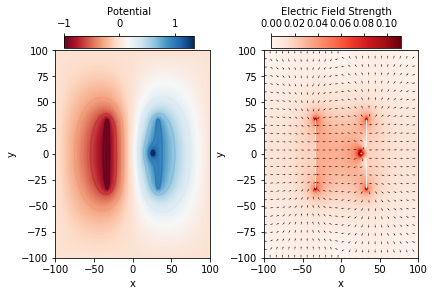

In [7]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# plot potential
m1 = ax1.pcolormesh(X, Y, phi, cmap = 'RdBu')

# add an axes to put colorbar is custom location
cax1 = fig.add_axes([0.14,0.87,0.3,0.04])
# create colorbar
cbar = fig.colorbar(m1,cax1, orientation = 'horizontal', ticklocation = 'top', ticks = [-1,0,1])
cbar.set_label('Potential')

# add contour lines
ax1.contour(X,Y,phi, cmap = 'RdBu')
ax1.set_xlabel("x")
ax1.set_ylabel("y")

# plot E-field 
m2 = ax2.pcolormesh(X,Y,magE, cmap = 'Reds')

cax2 = fig.add_axes([0.62,0.87,0.3,0.04])
cbar2 = fig.colorbar(m2,cax2,orientation = 'horizontal', ticklocation = 'top' )
cbar2.set_label('Electric Field Strength')
ax2.quiver(X[::8,::8],Y[::8,::8],EX[::8,::8], EY[::8, ::8], units = 'width') 
ax2.set_xlabel("x")
ax2.set_ylabel("y")


fig.subplots_adjust(left = 0.12,right = 0.96, bottom = 0.14, top = 0.86,wspace =0.35, hspace = 0.35)



**Notes:**

equations for an electric field:

$\nabla^2 V = -\rho/\epsilon_0$
$\nabla^2 V = 0$

Write out the Laplacian as a difference equation:

Forwards difference:
$\frac{\partial V}{\partial x} = \frac{V(i+1,j,k)-V(i,j,k)}{\Delta x} \Rightarrow V(i+1,j,k) = V(i,j,k) + \frac{\partial V}{\partial x} \Delta x + \frac{1}{2} \frac{\partial^2 V}{\partial x^2} (\Delta x)^2 + ...$

Backwards difference:
$V(i-1,j,k) = V(i,j,k) - \frac{\partial V}{\partial x} \Delta x - \frac{1}{2} \frac{\partial^2 V}{\partial x^2} (\Delta x)^2 + ...$

$\Rightarrow \frac{\partial^2 V}{\partial x^2} = \frac{1}{(\Delta x)^2} \left( V(i+1,j,k)+V(i-1,j,k)-2 V(i,j,k) \right)$

$\nabla^2 V = 0 \Rightarrow \frac{\partial^2 V}{\partial x^2} + \frac{\partial^2 V}{\partial y^2} + \frac{\partial^2 V}{\partial z^2} = 0$

Some other stuff happens to get the function that satisfies Poisson's equation (average of surrounding points) (equation *):
$V(i,j,k) = \frac{1}{6} \left( V(i+1,j,k)+V(i-1,j,k)+V(i,j,k+1)+V(i,j,k-1)++V(i,j+1,k)+V(i,j-1,k) \right)$

This is the equation in 3D that must be satisfied everwhere.  We know the boundary conditions for the problem so we fix V(i,j,k) on the boundary.  (problem is a cube that is grounded on the boundary)

*Procedure for finding $V(i,j,k)$:*

-Guess $V_0 (i,j,k) = V_0$

-New guess from putting $V_0$ in RHS of equation *

-LHS of * gives $V_{new}$

-Check $\sum(V_{new}(i,j,k)-V_{old}(i,j,k)) < \Delta V$

-Iterate

This procedure is called the Jacobi method (or the diffusion or relaxation method)

How small should $\Delta V$ (convergence criteiron) be?

reasonable estimate: $\frac{(\Delta V )/ (\text{number of sites})}{V_{boundary}} \approx 1*10^{-5}$


*Relaxation methods:*

$V_{new} = F(V_{old})$

Essentially turns a time-independent problem into a time-dependent problem.  We required that the long-time steady state solution of our time dependent PDE is a solution of our time-independent equation.

related to the heat/diffusion equation: $\frac{\partial \phi}{\partial t} = D \nabla^2 \phi$

This equation has some equilibrium limit.  In infinite time, the diffusion equation will turn into the Poisson equation since $\phi$ stops changing.